In [1]:
using IndexedGraphs, SparseArrays, MatrixProductBP, Random, Plots, Statistics
import ProgressMeter; ProgressMeter.ijulia_behavior(:clear);

# OBC

## MonteCarlo

In [3]:
# include("ising2d_montecarlo/IsingMC.jl");
include("ising2d_montecarlo/wolff.jl");

In [4]:
N = 10
T = N - 1
T1 = T + 1
d = (N, T1)
β = 0.5
J0 = 1.0
h0 = 1e-1

# h = sparse([fill(h0, prod(d)÷2); fill(-h0, prod(d)÷2)])
h = sparse(h0*randn(prod(d)))
# h = sparse(fill(h0, prod(d)))
# h = (1:N*T1) ./ (N*T1)
J = J0 * lattice(d, (true, true))

# delete bonds between spins (N,2N), (2N,3N) and so on, because they correspond to interaction xᵢ^ᵀ,xⱼ^ᵀ in
#  the dynamical model, which are not supported
bonds_to_delete = [(N*(T1-1)+i,N*(T1-1)+i+1) for i in 1:N-1]
for b in bonds_to_delete
   J[b...] = J[reverse(b)...] = 0 
end
dropzeros!(J);

In [5]:
rows, vals = rowvals(J), nonzeros(J)
neigs(i) = rows[nzrange(J, i)]
neigs(8)

3-element Vector{Int64}:
  7
  9
 18

In [7]:
ntherm = 10^4
nsamples = 10^5

stats = Stats(N*T1)

wolff(β*J, β*h, nsamples, stats; ntherm)
m_mc = magnetizations(stats);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


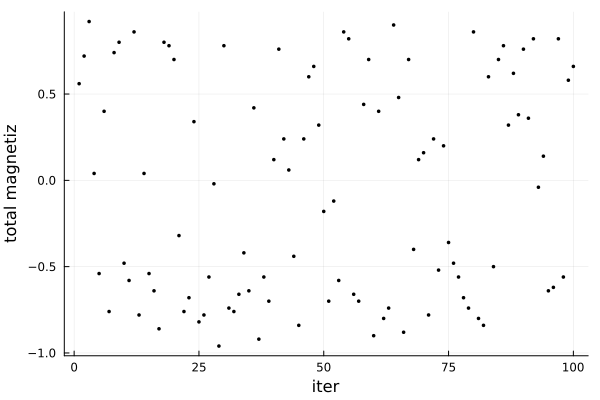

In [8]:
scatter(magnetization(stats)[1:1000:end], xlabel="iter", ylabel="total magnetiz", label="",
    ms=2, c=:black, msc=:auto)

In [9]:
reshape(m_mc, N, T1)

10×10 Matrix{Float64}:
  0.0616    0.03412  -0.04104  -0.06778  …  -0.06292  -0.10038  -0.09194
  0.03824   0.00088  -0.04684  -0.07426     -0.10544  -0.13828  -0.0976
  0.0087   -0.01912  -0.07102  -0.07224     -0.12024  -0.11784  -0.03764
 -0.03564  -0.04064  -0.08614  -0.10456     -0.0867   -0.05888  -0.023
 -0.0652   -0.08922  -0.11028  -0.10374     -0.08554  -0.09108  -0.05492
 -0.09674  -0.10374  -0.12514  -0.1196   …  -0.05008  -0.06554  -0.0123
 -0.14728  -0.14804  -0.12704  -0.12366     -0.02306  -0.02254  -0.04766
 -0.082    -0.12006  -0.12604  -0.11136      0.00152  -0.02268   0.02396
 -0.00218  -0.05772  -0.07332  -0.0756      -0.02028  -0.06452  -0.01526
 -0.02106  -0.0136   -0.07362  -0.0652      -0.01438   0.00996   0.07532

mean(m_mc) = -0.0654858


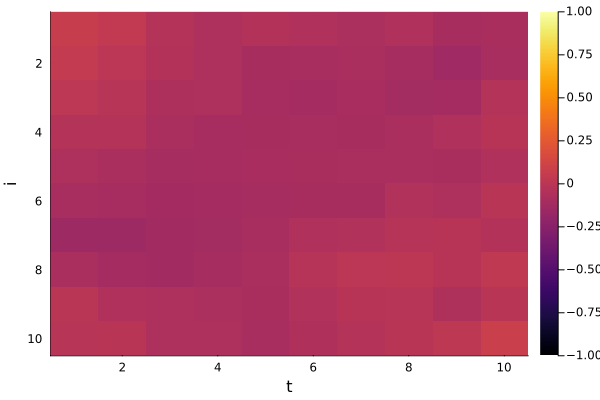

In [10]:
@show mean(m_mc)
heatmap(reshape(m_mc, N, T1), clims=(-1,1), xlabel="t", ylabel="i", yflip=true)

## MPBP

In [37]:
struct Ising2DOpen{T<:Real}  <: BPFactor 
    βJv :: T
    βJh :: T
    border :: Bool
end

spin(x, i = 0) = 3-2x

function (f::Ising2DOpen)(xᵢᵗ⁺¹::Integer,xₙᵢᵗ::AbstractVector{<:Integer}, xᵢᵗ::Integer)
    h = spin(xᵢᵗ)*(f.βJv*spin(xᵢᵗ⁺¹) + (f.border ? 0 : f.βJh*spin(xₙᵢᵗ[1])) )
    exp(h)
end

In [11]:
βJ = β * J0
# T = N - 1
G = IndexedBiDiGraph(chain(N, true))
h_matrix = reshape(h, N, T1)

w = [[Ising2DOpen(βJ, βJ, i==1) for t=0:T] for i=1:N]
ϕ = [[[exp(β*h_matrix[i,t]), exp(-β*h_matrix[i,t])] for t in 1:T+1] for i in 1:N]
bp = mpbp(G, w, fill(2,N), T; ϕ);

In [12]:
spin(x, i = 0) = 3-2x
cb = CB_BP(bp; f=spin);

In [13]:
svd_trunc = TruncBondThresh(10, 1e-10)
iters, cb = iterate!(bp, maxiter=80; svd_trunc, cb, tol=1e-5, damp=0.2);

Running MPBP: iter 11 	 Time: 0:00:22
  Δ:                  0.0
  SVD tolerance, m':  1.0e-10, 10

┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/mHQ0Q/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/mHQ0Q/src/ticks.jl:191


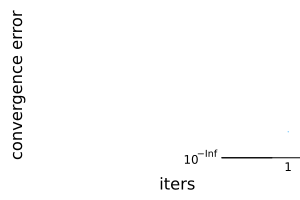

┌ Warning: Invalid negative or zero value 0.0 found at series index 11 for log10 based yscale
└ @ Plots ~/.julia/packages/Plots/esM5q/src/utils.jl:106
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/mHQ0Q/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/mHQ0Q/src/ticks.jl:191
┌ Warning: Invalid negative or zero value 0.0 found at series index 11 for log10 based yscale
└ @ Plots ~/.julia/packages/Plots/esM5q/src/utils.jl:106
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/mHQ0Q/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/mHQ0Q/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/mHQ0Q/src/ticks.jl:191
┌ Warning: Invalid negative or zero value 0.0 found at series index 11 for log10 based yscale
└ @ Plots ~/.julia/packages/Plots/esM5q/src/utils.jl:106


In [14]:
using Plots
plot(cb.Δs, ylabel="convergence error", xlabel="iters", yaxis=:log10, 
    size=(300,200), label="", xticks=1:(length(cb.Δs)÷3):length(cb.Δs))

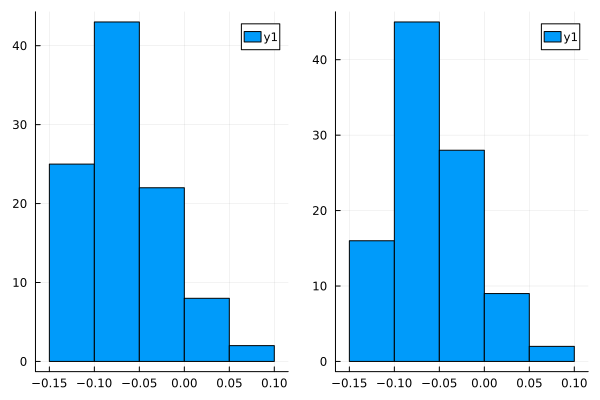

In [15]:
plot(histogram(m_mc, nbins=8), histogram(reduce(vcat, means(spin, bp)), nbins=8))
# heatmap(abs.(reduce(hcat, means(spin, bp)) .- reshape(m_mc,N,N)))
# abs.(reduce(hcat, means(spin, bp)) .- reshape(m_mc,N,N))

r = 0.9953313385020368


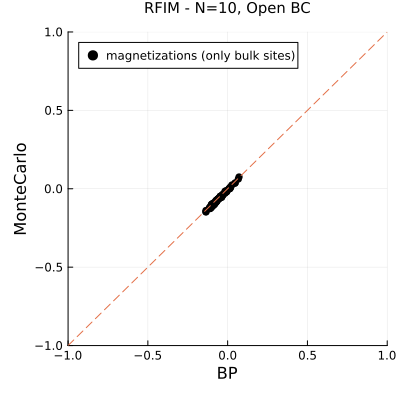

In [16]:
bulk = [LinearIndices((1:N,1:N))[i,j] for i in 1:N, j in 1:N if !(i==1 || j==1 || i==N || j==N)]
bulk = 1:N^2
scatter(permutedims(reduce(hcat, means(spin, bp)))[bulk], m_mc[bulk], xlims=(-1,1), ylims=(-1,1),
    ylabel="MonteCarlo", xlabel="BP", label="magnetizations (only bulk sites)",
    msc=:auto, c=:black)
plot!(identity, ls=:dash, label="")
lims = 1 .* (-1,1)
r = cor(permutedims(reduce(hcat, means(spin, bp)))[bulk], m_mc[bulk])
@show r
plot!(title="RFIM - N=$N, Open BC", size=(400,400), titlefontsize=10, xlims=lims, ylims=lims)

# OBC in 1 direction

## MonteCarlo

In [17]:
# include("ising2d_montecarlo/IsingMC.jl");
include("ising2d_montecarlo/wolff.jl");

In [279]:
N = 30
T = N-1
T1 = T + 1
d = (N, T1)
β = 0.5
J0 = 1.0
h0 = 1e-1

# h = sparse([fill(h0, prod(d)÷2); fill(-h0, prod(d)÷2)])
h = sparse(h0*randn(prod(d)))
# h = sparse(fill(h0, prod(d)))
# h = (1:N*T1) ./ (N*T1) .- 0.5
J = J0 * lattice(d, (false, true))

# delete bonds between spins (N,2N), (2N,3N) and so on, because they correspond to interaction xᵢ^ᵀ,xⱼ^ᵀ in
#  the dynamical model, which are not supported
bonds_to_delete = [(N*(T1-1)+i,N*(T1-1)+mod(i,N)+1) for i in 1:N]
for b in bonds_to_delete
   J[b...] = J[reverse(b)...] = 0 
end
dropzeros!(J);

In [280]:
ntherm = 10^4
nsamples = 10^5

stats = Stats(N*T1)

wolff(β*J, β*h, nsamples, stats; ntherm)
m_mc = magnetizations(stats);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:14


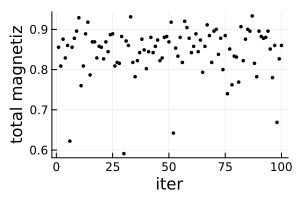

In [281]:
scatter(magnetization(stats)[1:1000:end], xlabel="iter", ylabel="total magnetiz", label="",
    ms=2, c=:black, msc=:auto, size=(300,200))

## MPBP

In [282]:
struct Ising2DPeriodic{T<:Real}  <: BPFactor 
    βJv :: T
    βJh :: T
    border :: Bool
end

spin(x, i = 0) = 3-2x

function (f::Ising2DPeriodic)(xᵢᵗ⁺¹::Integer,xₙᵢᵗ::AbstractVector{<:Integer}, xᵢᵗ::Integer)
    h = spin(xᵢᵗ)*(f.βJv*spin(xᵢᵗ⁺¹) + f.βJh*spin(xₙᵢᵗ[f.border ? 2 : 1]) )
    exp(h)
end

In [283]:
βJ = β * J0
# T = N - 1
G = IndexedBiDiGraph(chain(N, false))
h_matrix = reshape(h, N, T1)

w = [[Ising2DPeriodic(βJ, βJ, i == N || i == 1) for t=0:T] for i=1:N]
ϕ = [[[exp(β*h_matrix[i,t]), exp(-β*h_matrix[i,t])] for t in 1:T+1] for i in 1:N]
bp = mpbp(G, w, fill(2,N), T; ϕ);

In [284]:
spin(x, i = 0) = 3-2x
cb = CB_BP(bp; f=spin);

In [285]:
svd_trunc = TruncBondThresh(10, 1e-10)
maxiter = 100
iters, cb = iterate!(bp; maxiter, svd_trunc, cb, tol=1e-5, damp=0.2)
iters == maxiter && @warn "BP did not converge";

Running MPBP: iter 6 	 Time: 0:03:25
  Δ:                  0.07077108108861152
  SVD tolerance, m':  1.0e-10, 10

LoadError: TaskFailedException

[91m    nested task error: [39mInterruptException:
    Stacktrace:
      [1] [0m[1mreshape[22m
    [90m    @[39m [90m./[39m[90m[4mreshapedarray.jl:51[24m[39m[90m [inlined][39m
      [2] [0m[1mreshape[22m
    [90m    @[39m [90m./[39m[90m[4mreshapedarray.jl:111[24m[39m[90m [inlined][39m
      [3] [0m[1mmacro expansion[22m
    [90m    @[39m [90m~/.julia/packages/TensorCast/mQB8h/src/[39m[90m[4mmacro.jl:209[24m[39m[90m [inlined][39m
      [4] [0m[1mmpem2[22m[0m[1m([22m[90mB[39m::[0mMPEM3[90m{Float64}[39m[0m[1m)[22m
    [90m    @[39m [35mMatrixProductBP.MPEMs[39m [90m~/MatrixProductBP/src/MPEMs/[39m[90m[4mmpem3.jl:42[24m[39m
      [5] [0m[1monebpiter_dummy_neighbor[22m[0m[1m([22m[90mbp[39m::[0mMPBP[90m{IndexedBiDiGraph{Int64}, Float64, Vector{Ising2DPeriodic{Float64}}}[39m, [90mi[39m::[0mInt64; [90msvd_trunc[39m::[0mTruncBondThresh[90m{Float64}[39m[0m[1m)[22m
    [90m    @[39m [35mMatrixProductBP[39m [90m~/MatrixProductBP/src/[39m[90m[4mmpbp.jl:139[24m[39m
      [6] [0m[1monebpiter_dummy_neighbor[22m
    [90m    @[39m [90m~/MatrixProductBP/src/[39m[90m[4mmpbp.jl:132[24m[39m[90m [inlined][39m
      [7] [0m[1monebpiter![22m[0m[1m([22m[90mbp[39m::[0mMPBP[90m{IndexedBiDiGraph{Int64}, Float64, Vector{Ising2DPeriodic{Float64}}}[39m, [90mi[39m::[0mInt64, ::[0mType[90m{Ising2DPeriodic{Float64}}[39m; [90msvd_trunc[39m::[0mTruncBondThresh[90m{Float64}[39m, [90mdamp[39m::[0mFloat64[0m[1m)[22m
    [90m    @[39m [35mMatrixProductBP[39m [90m~/MatrixProductBP/src/[39m[90m[4mmpbp.jl:121[24m[39m
      [8] [0m[1monebpiter![22m
    [90m    @[39m [90m~/MatrixProductBP/src/[39m[90m[4mmpbp.jl:104[24m[39m[90m [inlined][39m
      [9] [0m[1mmacro expansion[22m
    [90m    @[39m [90m~/MatrixProductBP/src/[39m[90m[4mmpbp.jl:178[24m[39m[90m [inlined][39m
     [10] [0m[1m(::MatrixProductBP.var"#205#threadsfor_fun#85"{MatrixProductBP.var"#205#threadsfor_fun#84#86"{TruncBondThresh{Float64}, Float64, MPBP{IndexedBiDiGraph{Int64}, Float64, Vector{Ising2DPeriodic{Float64}}}, Vector{Int64}}})[22m[0m[1m([22m[90mtid[39m::[0mInt64; [90monethread[39m::[0mBool[0m[1m)[22m
    [90m    @[39m [35mMatrixProductBP[39m [90m./[39m[90m[4mthreadingconstructs.jl:163[24m[39m
     [11] [0m[1m#205#threadsfor_fun[22m
    [90m    @[39m [90m./[39m[90m[4mthreadingconstructs.jl:130[24m[39m[90m [inlined][39m
     [12] [0m[1m(::Base.Threads.var"#1#2"{MatrixProductBP.var"#205#threadsfor_fun#85"{MatrixProductBP.var"#205#threadsfor_fun#84#86"{TruncBondThresh{Float64}, Float64, MPBP{IndexedBiDiGraph{Int64}, Float64, Vector{Ising2DPeriodic{Float64}}}, Vector{Int64}}}, Int64})[22m[0m[1m([22m[0m[1m)[22m
    [90m    @[39m [90mBase.Threads[39m [90m./[39m[90m[4mthreadingconstructs.jl:108[24m[39m

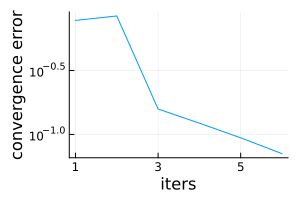

In [286]:
using Plots
plot(cb.Δs, ylabel="convergence error", xlabel="iters", yaxis=:log10, 
    size=(300,200), label="", xticks=1:(length(cb.Δs)÷3):length(cb.Δs))

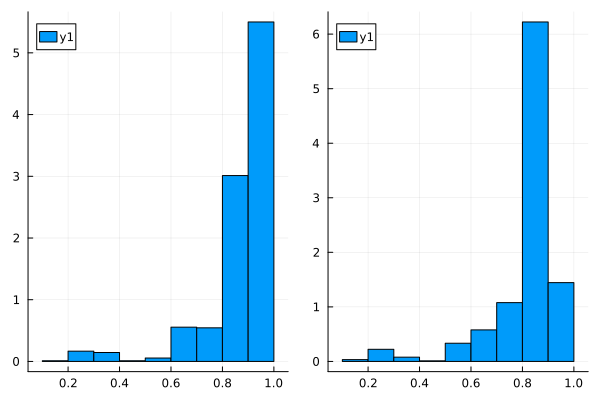

In [287]:
plot( histogram(m_mc, nbins=8, normalize=true), 
      histogram(reduce(vcat, means(spin, bp)), nbins=8, normalize=true) )
# heatmap(abs.(reduce(hcat, means(spin, bp)) .- reshape(m_mc,N,N)))
# abs.(reduce(hcat, means(spin, bp)) .- reshape(m_mc,N,N))

r = 0.987696354689984


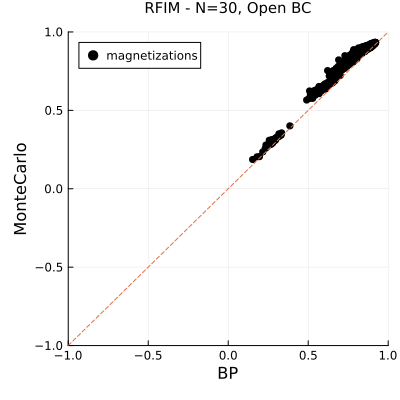

In [288]:
scatter(permutedims(reduce(hcat, means(spin, bp)))[:], m_mc, xlims=(-1,1), ylims=(-1,1),
    ylabel="MonteCarlo", xlabel="BP", label="magnetizations",
    msc=:auto, c=:black)
plot!(identity, ls=:dash, label="")
lims = 1 .* (-1,1)
r = cor(permutedims(reduce(hcat, means(spin, bp)))[:], m_mc)
@show r
plot!(title="RFIM - N=$N, Open BC", size=(400,400), titlefontsize=10, xlims=lims, ylims=lims)

# Increasing size

In [ ]:
Ns = 30:5:50
ms_mc = zeros(length(Ns))
ms_bp = zeros(length(Ns))

β = 0.5
J = 1.0
h0 = 0.1

for j in eachindex(Ns)
    N = Ns[j]
    println("Size $j of $(length(Ns)) - N=$N")
    println("-- MonteCarlo")
    I = (N, N)
    meas = mcising(I, β; h = h0 * randn(prod(I)), J = [J*ones(2^length(I)) for _ in 1:prod(I)], 
        nterm=10, nmeas=5*10^2, nsweep=5*10^2)
    ms_mc[j] = mean(abs, meas.mag)
    
    println("-- BP")
    T = N
    G = IndexedBiDiGraph(periodicchain(20))
    w = [[Ising2D(β*J, β*J, βh0*randn(rng)) for t=0:T] for i in vertices(G)]
    bp = mpbp(G, w, fill(2,N), T)
    cb = CB_BP(bp; f=spin, showprogress=false)
    svd_trunc = TruncBondThresh(6, 1e-6)
    iters, cb = iterate!(bp, maxiter=50; svd_trunc, cb, tol=1e-3, damp=0.2)
    m_bp = means(spin, bp)
    ms_bp[j] = mean(abs, m[t] for m in m_bp, t in (T÷4:T÷4*3))
end

Size 1 of 5 - N=30
-- MonteCarlo
-- BP
Size 2 of 5 - N=35
-- MonteCarlo
-- BP
Size 3 of 5 - N=40
-- MonteCarlo
-- BP
Size 4 of 5 - N=45
-- MonteCarlo
-- BP


In [ ]:
scatter(Ns, ms_mc, label="MonteCarlo", xlabel="N", ylabel="magnetization")
scatter!(Ns, ms_bp, label="BP")

## Infinite graph

In [46]:
N = 100
I = (N, N)
meas = mcising(I, β; h = h0 * randn(prod(I)), J = [J*ones(2^length(I)) for _ in 1:prod(I)], 
    nterm=20, nmeas=5*10^2, nsweep=2*10^2)
mean(abs, meas.mag)

0.9093336

In [36]:
T = N
wᵢ = [Ising2D(β*J, β*J, β*h0*randn()) for _ in 1:T+1]

bp_inf = mpbp_infinite_graph(2, wᵢ, 2)
cb = CB_BP(bp_inf; f=spin, showprogress=false)

In [37]:
svd_trunc = TruncBondThresh(8, 1e-6)
iters, cb = iterate!(bp_inf, maxiter=50; svd_trunc, cb, tol=1e-3, damp=0.2);

In [45]:
m_bp = means(spin, bp_inf)
mean(abs, m[t] for m in m_bp, t in (T÷4:T÷4*3))

0.9118196875948974

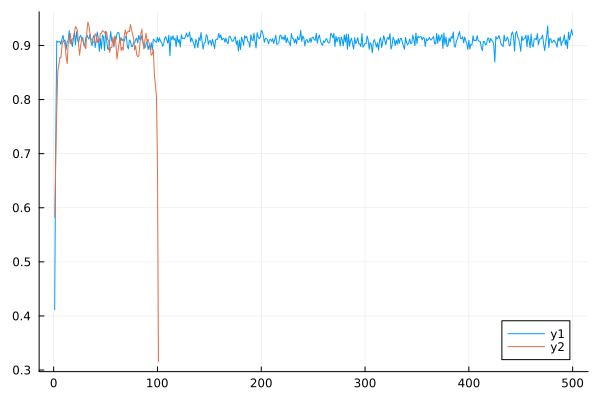

In [44]:
plot(meas.mag)
plot!(only(m_bp))

In [74]:
Ns = 100:20:140
ms_mc = zeros(length(Ns))
ms_bp = zeros(length(Ns))
meass = []
bps = []
cbs = []

β = 0.5
J = 1.0
h0 = 0.1

for j in eachindex(Ns)
    N = Ns[j]
    println("Size $j of $(length(Ns)) - N=$N")
    println("-- MonteCarlo")
    I = (N, N)
    meas = mcising(I, β; h = h0 * randn(prod(I)), J = [J*ones(2^length(I)) for _ in 1:prod(I)], 
        nterm=300, nmeas=5*10^2, nsweep=2*10^2)
    ms_mc[j] = mean(abs, meas.mag)
    
    println("-- BP")
    T = N
    wᵢ = [Ising2D(β*J, β*J, β*h0*randn()) for _ in 1:T+1]
    bp_inf = mpbp_infinite_graph(2, wᵢ, 2)
    cb = CB_BP(bp_inf; f=spin, showprogress=false)
    svd_trunc = TruncBondThresh(8, 1e-7)
    iters, cb = iterate!(bp_inf, maxiter=100; svd_trunc, cb, tol=1e-3, damp=0.2)
    m_bp = means(spin, bp_inf)
    ms_bp[j] = mean(abs, m[t] for m in m_bp, t in (T÷4:T÷4*3))
    
    push!(meass, meas); push!(bps, bp_inf); push!(cbs, cb)
end

Size 1 of 3 - N=100
-- MonteCarlo
-- BP
Size 2 of 3 - N=120
-- MonteCarlo
-- BP
Size 3 of 3 - N=140
-- MonteCarlo
-- BP


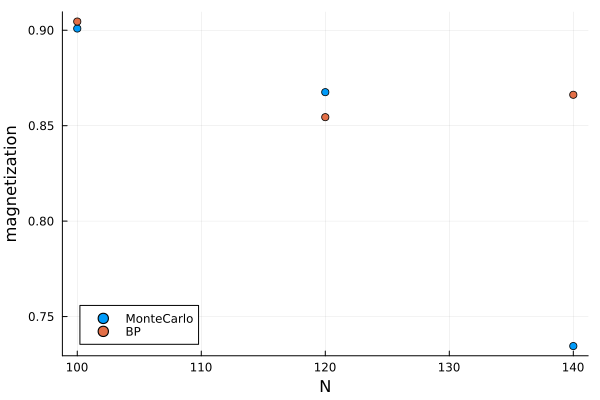

In [75]:
scatter(Ns, ms_mc, label="MonteCarlo", xlabel="N", ylabel="magnetization")
scatter!(Ns, ms_bp, label="BP")

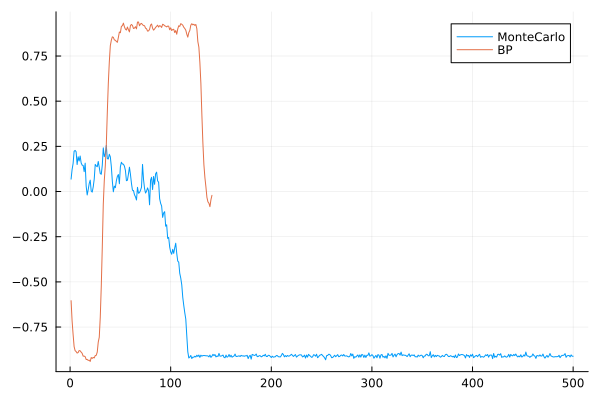

In [77]:
i = 3
plot(meass[i].mag, label="MonteCarlo")
plot!(only(means(spin, bps[i])), label="BP")